In [1]:
!pip install tensorflow
!pip install transformers
!pip install torch
!pip install pydot
!pip install graphviz 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.4 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 6.7 MB/s eta 0:00:00

In [2]:
import torch
import transformers
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

2023-05-07 00:50:14.481877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 00:50:16.432202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
sentence_length=64
e1=[]
e3=[]

In [9]:
data = pd.read_csv('Input_data.csv')
data_leipzig_news = pd.read_pickle('Leipzig News Corpora')

#### Determining Complexity

In [11]:
Primary_school_data = pd.DataFrame(data_leipzig_news.loc[data_leipzig_news['text_standard']=='0th and 1st grade','Sentence'])
Primary_school_data['Word Count'] = Primary_school_data['Sentence'].apply(lambda x: len(str(x).split(' ')))
Primary_school_trimmed = Primary_school_data.loc[(Primary_school_data['Word Count']>=20) & (Primary_school_data['Word Count']<=30),'Sentence']

Primary_school_trimmed = pd.DataFrame(Primary_school_trimmed)
Primary_school_trimmed['iso'] = 'eng'
Primary_school_trimmed['complexity'] = 0

In [12]:
Secondary_school_data = pd.DataFrame(data_leipzig_news.loc[data_leipzig_news['text_standard']=='1st and 2nd grade','Sentence'])
Secondary_school_data['Word Count'] = Secondary_school_data['Sentence'].apply(lambda x: len(str(x).split(' ')))
Secondary_school_data_trimmed = Secondary_school_data.loc[(Secondary_school_data['Word Count']>=20) & (Secondary_school_data['Word Count']<=30),'Sentence']

Secondary_school_data_trimmed = pd.DataFrame(Secondary_school_data_trimmed)
Secondary_school_data_trimmed['iso'] = 'eng'
Secondary_school_data_trimmed['complexity'] = 0


In [13]:
Primary = pd.concat([Primary_school_trimmed,Secondary_school_data_trimmed], axis=0)

In [14]:
University_data = pd.DataFrame(data_leipzig_news.loc[data_leipzig_news['text_standard']=='18th and 19th grade','Sentence'])
University_data['Word Count'] = University_data['Sentence'].apply(lambda x: len(str(x).split(' ')))
University_data_trimmed = University_data.loc[(University_data['Word Count']>=20) & (University_data['Word Count']<=30),'Sentence']
University_data_trimmed = University_data_trimmed.sample(frac=0.12)

University_data_trimmed = pd.DataFrame(University_data_trimmed)
University_data_trimmed['iso'] = 'eng'
University_data_trimmed['complexity'] = 1

In [15]:
english_dataset = pd.concat([Primary,University_data_trimmed], axis=0)
english_dataset = english_dataset.rename(columns = {'Sentence':'text'})
english_dataset.to_csv('English_dataset.csv')

english_dataset = english_dataset[['iso','complexity','text']]

In [16]:
data = data[['iso','complexity','text']]
data_4train = pd.concat([data,english_dataset], axis=0)

In [17]:
data_4train.to_csv('final_data.csv')
data_4train.reset_index(inplace=True)

In [9]:
#testing validation split with encoding
def train_val(dataset,val):

    dataset=dataset
    val=0.2
        
    labels=np.array(dataset.complexity.values,dtype=np.float16)
    
    if val != 0:
        train_idx, val_idx = train_test_split(
            np.arange(len(labels)),
            test_size = val,
            shuffle = True,
            stratify = labels)
    else:
        train_idx=np.array([*range(len(dataset))])
        val_idx=[]
    
    texts=dataset.text.values
    languages = dataset.iso.values

    t1=texts[train_idx]
    t2=labels[train_idx]
    t5=languages[train_idx]
    
    t3=texts[val_idx]
    t4=labels[val_idx]
    t6 = languages[val_idx]
    
    for i in range(len(t1)):    

        input_ids = labse_tokenizer.encode(t1[i], add_special_tokens=True, return_tensors="tf",padding='max_length',max_length=sentence_length,truncation=True)
        outputs = labse_model(input_ids, output_hidden_states=True)
        sequence_output = outputs.hidden_states[-4:]    # getting last 4 layers
        embedding=np.array([np.array(sequence_output[j])[0] for j in range(len(sequence_output))])
        embedding=embedding.reshape((64,768,4))  #reshaping to fit the convolution layer
        e1.append(embedding)                     
            
    if val != 0:
        
        for i in range(len(t3)):
        
            input_ids = labse_tokenizer.encode(t3[i], add_special_tokens=True, return_tensors="tf",padding='max_length',max_length=64,truncation=True)
            outputs = labse_model(input_ids, output_hidden_states=True)
            sequence_output = outputs.hidden_states[-4:]
            embedding=np.array([np.array(sequence_output[j])[0] for j in range(len(sequence_output))])
            embedding=embedding.reshape((64,768,4))
            e3.append(embedding)
    
    return e1, t2, e3, t4, t5, t6, train_idx,val_idx


In [201]:
train_x,train_y,val_x,val_y, train_lang, val_lang, train_idx,val_idx =train_val(data_4train,0.2)

train_x=np.array(train_x)
val_x=np.array(val_x)
train_y=np.array(train_y)
val_y=np.array(val_y)

#### Saving it for later use

In [202]:
np.save('train_x.npy',train_x)
np.save('val_x.npy',val_x)
np.save('train_y.npy',train_y)
np.save('val_y.npy',val_y)
np.save('train_lang.npy',train_lang)
np.save('val_lang.npy',val_lang)
np.save('train_idx.npy',train_idx)
np.save('val_idx.npy',val_idx)

#### Load only if necessary

In [10]:
train_x=np.load('train_x.npy')
val_x=np.load('val_x.npy')
train_y=np.load('train_y.npy')
val_y=np.load('val_y.npy')
train_lang=np.load('train_lang.npy', allow_pickle=True)
val_lang=np.load('val_lang.npy', allow_pickle=True)
train_idx=np.load('train_idx.npy')
val_idx=np.load('val_idx.npy')

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from keras.optimizers import Adam
from keras.layers import Dropout, LeakyReLU
from keras.regularizers import l2

# reshape the input array to a 5D shape
input_array = np.reshape(cassie_leizpig_train_x, (33922, 64, 768, 4, 1))
labels = cassie_leizpig_train_y

# create an LSTM model with a ConvLSTM20D layer
model = Sequential()
model.add(ConvLSTM2D(64, (3,3), activation='relu', input_shape=(64, 768, 4, 1), padding='same', return_sequences=True))
model.add(Dropout(0.5))
model.add(ConvLSTM2D(32, (3,3), activation='relu', padding='same', return_sequences=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(input_array, labels, epochs=10, batch_size=64)

Epoch 1/10


2023-03-11 23:46:09.058141: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26677346304 exceeds 10% of free system memory.


531/531 [==============================] - 220s 406ms/step - loss: 0.4266 - accuracy: 0.8262
Epoch 2/10
531/531 [==============================] - 216s 407ms/step - loss: 0.2822 - accuracy: 0.8808
Epoch 3/10
531/531 [==============================] - 216s 407ms/step - loss: 0.2308 - accuracy: 0.9011
Epoch 4/10
531/531 [==============================] - 217s 409ms/step - loss: 0.2024 - accuracy: 0.9112
Epoch 5/10
531/531 [==============================] - 217s 409ms/step - loss: 0.1663 - accuracy: 0.9257
Epoch 6/10
531/531 [==============================] - 217s 409ms/step - loss: 0.1459 - accuracy: 0.9355
Epoch 7/10
531/531 [==============================] - 217s 409ms/step - loss: 0.1286 - accuracy: 0.9427
Epoch 8/10
531/531 [==============================] - 217s 409ms/step - loss: 0.1067 - accuracy: 0.9519
Epoch 9/10
531/531 [==============================] - 217s 409ms/step - loss: 0.0946 - accuracy: 0.9580
Epoch 10/10
531/531 [==============================] - 217s 409ms/step - lo

In [48]:
### Saving Model Object

model.save('Model_96%_acc.h5')

In [5]:
### Load Model only if necessary

from keras.models import load_model
loaded_model = load_model('Model_96%_acc.h5')

2023-03-29 19:24:36.857394: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [18]:
# Predict using the model
val_pred = model.predict(val_x)

266/266 [==============================] - 26s 96ms/step


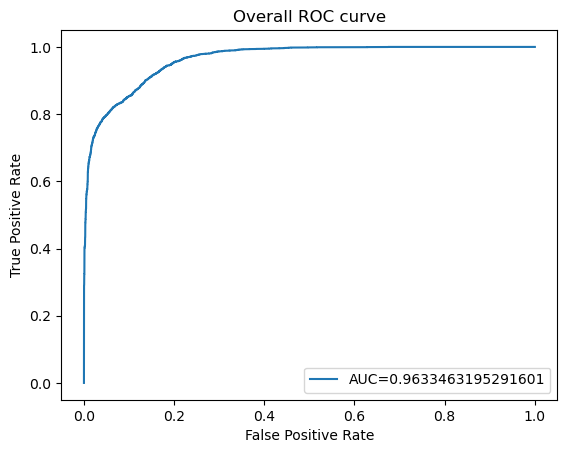

In [19]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(val_y,val_pred)
auc = metrics.roc_auc_score(val_y,val_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Overall ROC curve")
plt.legend(loc=4)
plt.show()

In [9]:
train_lang=np.load('train_lang.npy', allow_pickle=True)
val_lang=np.load('val_lang.npy', allow_pickle=True)

In [23]:
language_index = []
for index, value in enumerate(val_lang):
    if value=='eng':
        language_index.append(index)
    else:
        continue


In [24]:
val_x_lang = val_x[language_index]
val_y_lang = val_y[language_index]

In [25]:
# Predict using the model for sepecific language
val_pred_lang = model.predict(val_x_lang)

112/112 [==============================] - 11s 96ms/step


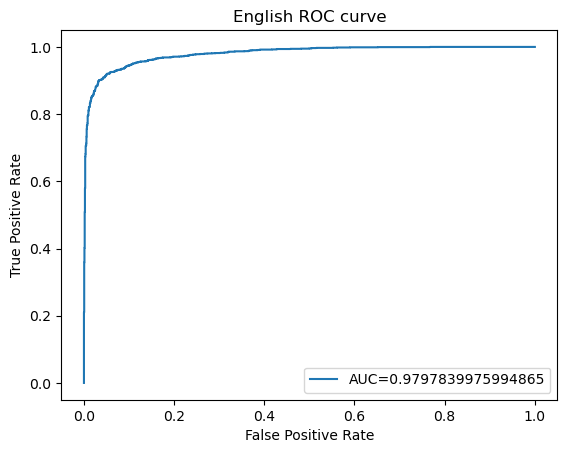

In [248]:
#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(val_y_lang, val_pred_lang)
auc = metrics.roc_auc_score(val_y_lang, val_pred_lang)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("English ROC curve")
plt.legend(loc=4)
plt.show()

In [20]:
### Use the ISO code for the relevant language and assign to variable "value" in the below code

1/1 [==============================] - 0s 103ms/step


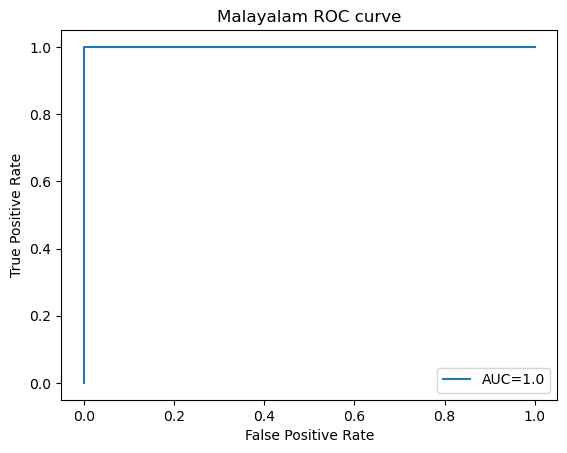

In [27]:
language_index = []
for index, value in enumerate(val_lang):
    if value=='mal':
        language_index.append(index)
    else:
        continue

val_x_lang = val_x[language_index]
val_y_lang = val_y[language_index]
# Predict using the model for sepecific language
val_pred_lang = model.predict(val_x_lang)

#create ROC curve
fpr, tpr, thresholds = metrics.roc_curve(val_y_lang, val_pred_lang)
auc = metrics.roc_auc_score(val_y_lang, val_pred_lang)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Malayalam ROC curve")
plt.legend(loc=4)
plt.show()